In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_hub as hub
from imblearn.over_sampling import RandomOverSampler

In [2]:
df=pd.read_csv("wine-reviews.csv",usecols=['country','description','points','price','variety','winery'])


In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df=df.dropna(subset=['description','points'])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


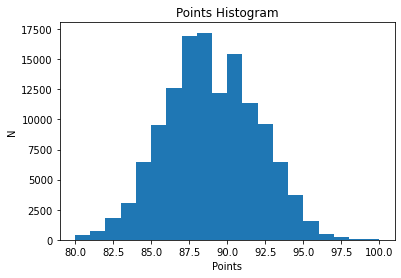

In [6]:
plt.hist(df.points,bins=20)
plt.title('Points Histogram')
plt.ylabel('N')
plt.xlabel('Points')
plt.show()

In [7]:
df["label"]=(df.points>=90).astype(int)
df=df[["description","label"]]

In [8]:
train,val,test=np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [10]:
train_data=df_to_dataset(train)
valid_data=df_to_dataset(val)
test_data=df_to_dataset(test)

In [11]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Packaged in a squat, medallion-shaped bottle, this fragrant Moscato Giallo offers a full bouquet of peach blossom, honey, acacia flower and jasmine. It's sweet and tangy in the mouth to the right measure and would pair with fruit salad or apricot tarts.",
        b'This blend of Chardonnay (70%) and Sauvignon opens with a touch of bitter almond followed by peach, apricot and pineapple. Warm climate characteristics of smooth, creamy fruit are definitely evident in this white wine from coastal Tuscany.',
        b'A bright fruity nose of tart cherry and cranberry yields to surprisingly sophisticated flavors of ripe black cherry, blackberry, coffee and white chocolate. Mouth-coating tannins are at play on the palate, culminating in a finish marked by a lingering sense of zestiness.',
        ...,
        b"Food friendly, this has soft tones of peach and melon. There's a touch of fresh acidity that helps to smooth out the naturally

#Embedding+Model


In [12]:
embedding="https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding,dtype=tf.string,trainable=True)

In [13]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.23934029, -0.53207076, -0.09509956, ..., -0.04847834,
        -0.2823926 , -0.04206932],
       [ 0.40832174, -0.06843908, -0.21609138, ..., -0.13914064,
        -0.13923368,  0.20195171],
       [ 0.35811174, -0.4482182 , -0.07845972, ...,  0.03077647,
        -0.16220737,  0.00623685],
       ...,
       [ 0.29998314, -0.09475371, -0.01461586, ...,  0.13137588,
        -0.0867645 , -0.0918154 ],
       [ 0.13843413, -0.05080652,  0.02249276, ...,  0.02435032,
         0.01496163, -0.0465267 ],
       [ 0.41910967, -0.19721074,  0.10103465, ..., -0.20091271,
        -0.28590354, -0.07193504]], dtype=float32)>

In [14]:
model=tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [16]:
model.evaluate(train_data)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


102/102 [==============================] - 3s 21ms/step - loss: 0.7028 - accuracy: 0.4472


[0.7028445601463318, 0.44719934463500977]

In [17]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 28ms/step - loss: 0.7031 - accuracy: 0.4482


[0.7031081914901733, 0.44818034768104553]

In [18]:
history=model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 156s 1s/step - loss: 0.6284 - accuracy: 0.6287 - val_loss: 0.5049 - val_accuracy: 0.7690
Epoch 2/5
102/102 [==============================] - 134s 1s/step - loss: 0.4657 - accuracy: 0.7844 - val_loss: 0.4033 - val_accuracy: 0.8129
Epoch 3/5
102/102 [==============================] - 136s 1s/step - loss: 0.3939 - accuracy: 0.8305 - val_loss: 0.3858 - val_accuracy: 0.8183
Epoch 4/5
102/102 [==============================] - 133s 1s/step - loss: 0.3579 - accuracy: 0.8489 - val_loss: 0.3788 - val_accuracy: 0.8250
Epoch 5/5
102/102 [==============================] - 147s 1s/step - loss: 0.3331 - accuracy: 0.8602 - val_loss: 0.3813 - val_accuracy: 0.8278


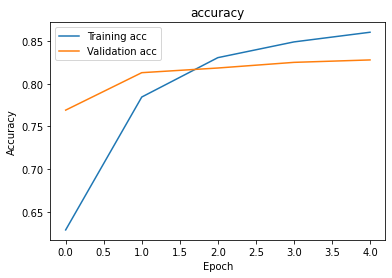

In [19]:
plt.plot(history.history['accuracy'],label="Training acc")
plt.plot(history.history['val_accuracy'],label="Validation acc")
plt.title("accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

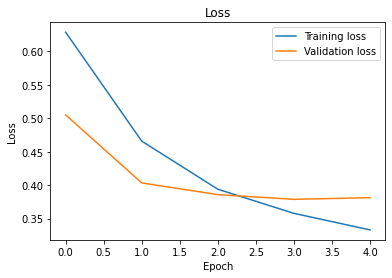

In [20]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [21]:
model.evaluate(test_data)

13/13 [==============================] - 2s 172ms/step - loss: 0.3774 - accuracy: 0.8297


[0.37744253873825073, 0.8297430276870728]

# LSTM

In [29]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [30]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [31]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [33]:
model.evaluate(train_data)
model.evaluate(valid_data)


13/13 [==============================] - 2s 186ms/step - loss: 0.6937 - accuracy: 0.4152


[0.6937169432640076, 0.4151727259159088]

In [34]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 63s 551ms/step - loss: 0.5394 - accuracy: 0.7179 - val_loss: 0.3869 - val_accuracy: 0.8225
Epoch 2/5
102/102 [==============================] - 59s 580ms/step - loss: 0.3634 - accuracy: 0.8373 - val_loss: 0.3649 - val_accuracy: 0.8350
Epoch 3/5
102/102 [==============================] - 56s 544ms/step - loss: 0.3476 - accuracy: 0.8450 - val_loss: 0.3588 - val_accuracy: 0.8367
Epoch 4/5
102/102 [==============================] - 56s 548ms/step - loss: 0.3403 - accuracy: 0.8477 - val_loss: 0.3539 - val_accuracy: 0.8387
Epoch 5/5
102/102 [==============================] - 58s 568ms/step - loss: 0.3364 - accuracy: 0.8498 - val_loss: 0.3508 - val_accuracy: 0.8407


In [36]:
model.evaluate(test_data)

13/13 [==============================] - 3s 190ms/step - loss: 0.3528 - accuracy: 0.8369


[0.35283371806144714, 0.8368979692459106]